In [1]:
import calendar
import numpy as np
import pandas as pd
import seaborn as sn
import missingno as msno
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
# Reading the data
data = pd.read_csv('hour.csv', sep = ',')

In [3]:
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


Since the dataset already has integer values for seasons and weathers, we assign a value to each of them so that it is easier to analyse in the future. These values are already described in the dataset file itself (by Kaggle).

In [4]:
seasonMap = {1:"Spring", 2 :"Summer", 3 :"Fall", 4 :"Winter" }
weatherMap = {1: " Clear + Few clouds + Partly cloudy + Partly cloudy",\
              2 : " Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist ", \
              3 : " Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds", \
              4 :" Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog " }

In [5]:
# Separate the date
data["date"] = data.dteday.apply(lambda x : x.split()[0])

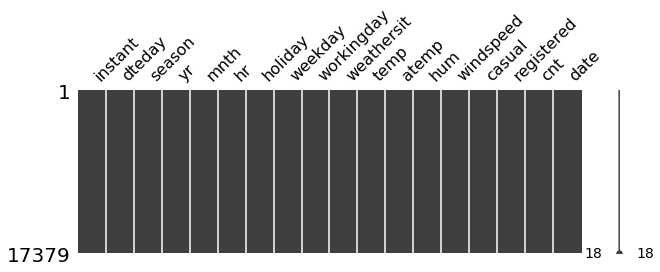

In [6]:
# Missing data detection
msno.matrix(data,figsize=(10,3))

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Working Day'),
 Text(0.5, 1.0, 'Box Plot On Count/Working Day Distribution')]

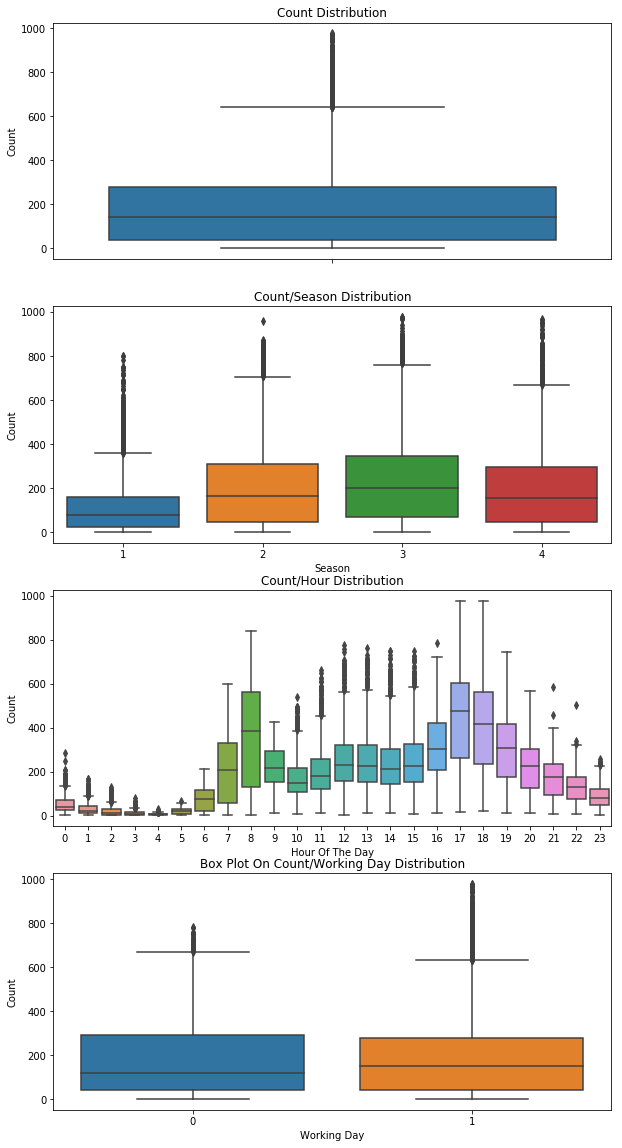

In [7]:
# Outliners detection
fig, axes = plt.subplots(nrows=4,ncols=1)
fig.set_size_inches(10, 20)

#Distribution of the data plot
sn.boxplot(data=data,y="cnt",orient="v",ax=axes[0])

#Distribution of the data per season
sn.boxplot(data=data,y="cnt",x="season",orient="v",ax=axes[1])

#Distribution of data per hour
sn.boxplot(data=data,y="cnt",x="hr",orient="v",ax=axes[2])

#Distribution of data on the basis of working day or holiday
sn.boxplot(data=data,y="cnt",x="workingday",orient="v",ax=axes[3])
axes[0].set(ylabel='Count',title="Count Distribution")
axes[1].set(xlabel='Season', ylabel='Count',title="Count/Season Distribution")
axes[2].set(xlabel='Hour Of The Day', ylabel='Count',title="Count/Hour Distribution")
axes[3].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count/Working Day Distribution")

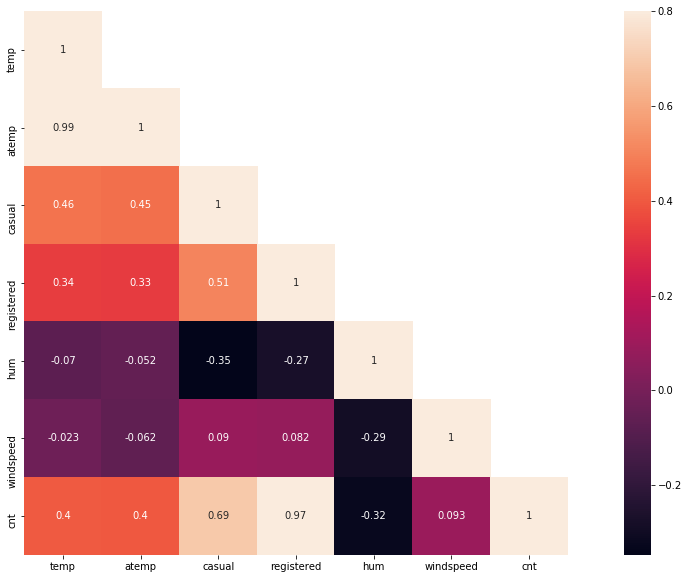

In [8]:
# Correlation analasys
corrMatt = data[["temp","atemp","casual","registered","hum","windspeed","cnt"]].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

I wanted to check the influence of these features on the count of the bikes. The registered feature has a very high correlation with the count, so I want to remove it because it might have a very positive influence on the model which is not desirable. 
Also since windspeed has very less correlation with count, I will remove that also from the model.

In [9]:
# Categorical Features and drop features
categoricalFeatureNames = ["season","holiday","workingday","weathersit","weekday","mnth","yr","hr"]
numericalFeatureNames = ["temp","hum","windspeed","atemp", "casual"]
dropFeatures = ["cnt","dteday","date","registered"]

In [10]:
for var in categoricalFeatureNames:
    data[var] = data[var].astype("category")

In [11]:
# Build Train and test data
data = data[pd.notnull(data['cnt'])].sort_values(by=["dteday"])
y = data["cnt"]

In [12]:
data  = data.drop(dropFeatures,axis=1)

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( data, y, test_size=0.3, random_state=42)

In [14]:
# Create model
from sklearn.ensemble import RandomForestRegressor
rfModel = RandomForestRegressor(n_estimators=500)
rfModel.fit(X = X_train,y = np.log1p(y_train))
preds = rfModel.predict(X= X_test)


I will be using Root Mean Square Log Error to calcaluate the error between the predicted and the actual vlaues. This metric penalises the underestimates more than the overestimates. 

In [15]:
# Analyze the results
def rmsle(y, y_,convertExp=True):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

print ("RMSLE Value For Random Forest: ",rmsle(np.exp(np.log1p(y_test)),np.exp(preds),False))

RMSLE Value For Random Forest:  0.24509317013407048


# Which Feature had the most impact?
My main aim was to see which of the feature imopacted the model and predictions the most

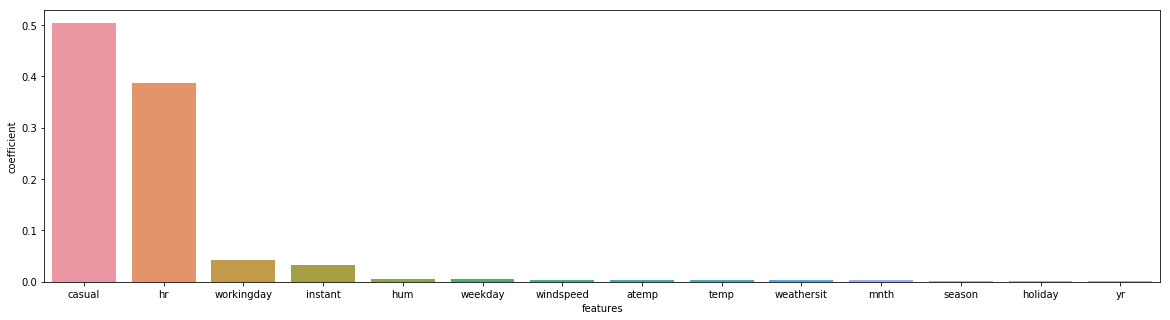

In [16]:
features = pd.DataFrame()
features['features'] = X_train.columns
features['coefficient'] = rfModel.feature_importances_
features.sort_values(by=['coefficient'],ascending=False,inplace=True)
fig,ax= plt.subplots()
fig.set_size_inches(20,5)
sn.barplot(data=features,x="features",y="coefficient",ax=ax)